# GitHub analysis client
This notebook assumes that Pulsar is running and there are already partial results available

In [1]:
import matplotlib.pyplot as plt
import operator
import os
import pandas as pd
import sortedcontainers
from pulsar_wrapper import PulsarConnection

In [2]:
class LanguageTuple(object):
    """ Data Type to support tuple in-place sorting using sortedcontainers """
    def __init__(self, lang_tuple):
        self.lang = lang_tuple[0]
        self.value = int(lang_tuple[1] or 0)
        
    def __repr__(self):
        return f"('{self.lang}', {self.value})"

def sort_results(language_stats, field, num_results=None):
    lang_repos = sortedcontainers.SortedKeyList(key=lambda x: -x.value)
    for language in language_stats:
        lang_repos.add(LanguageTuple((language, language_stats[language][field])))
    return list(lang_repos[:num_results])

In [3]:
# Function to plot the results
def plot_result(result_tuple, title='', xlabel='', ylabel=''):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    x_axis = [val.lang for val in result_tuple]
    y_axis = [val.value for val in result_tuple]
    plt.bar(range(len(result_tuple)), y_axis, tick_label=x_axis)
    plt.show()

In [4]:
# Take Pulsar host value from the environment variables
environment = os.environ
pulsar_host = environment.get("pulsar_host")
# If not set, assume its running in localhost
if (pulsar_host is None): pulsar_host = 'localhost'
my_pulsar = PulsarConnection(ip_address=pulsar_host)

2022-06-03 19:24:45.512 INFO  [140320932513600] ClientConnection:189 | [<none> -> pulsar://localhost:6650] Create ClientConnection, timeout=10000
2022-06-03 19:24:45.512 INFO  [140320932513600] ConnectionPool:96 | Created connection for pulsar://localhost:6650
2022-06-03 19:24:45.518 INFO  [140319980427008] ClientConnection:375 | [127.0.0.1:55018 -> 127.0.0.1:6650] Connected to broker
2022-06-03 19:24:45.529 INFO  [140319980427008] HandlerBase:64 | [persistent://public/static/initialized, reader-7a08787921, 0] Getting connection from pool
2022-06-03 19:24:45.532 INFO  [140319980427008] ConsumerImpl:224 | [persistent://public/static/initialized, reader-7a08787921, 0] Created consumer on broker [127.0.0.1:55018 -> 127.0.0.1:6650] 
Found 'Initializing' message
Found 'Initialized' message
2022-06-03 19:24:45.535 INFO  [140320932513600] ConsumerImpl:999 | [persistent://public/static/initialized, reader-7a08787921, 0] Closing consumer for topic persistent://public/static/initialized
2022-06-

In [5]:
cur_cutoff_date = my_pulsar.get_current_cuttoff_date()

2022-06-03 19:24:52.641 INFO  [140319980427008] HandlerBase:64 | [persistent://public/static/initialized, reader-c736ce30d2, 1] Getting connection from pool
2022-06-03 19:24:52.643 INFO  [140319980427008] ConsumerImpl:224 | [persistent://public/static/initialized, reader-c736ce30d2, 1] Created consumer on broker [127.0.0.1:55018 -> 127.0.0.1:6650] 
2022-06-03 19:24:52.648 INFO  [140320932513600] ConsumerImpl:999 | [persistent://public/static/initialized, reader-c736ce30d2, 1] Closing consumer for topic persistent://public/static/initialized
2022-06-03 19:24:52.649 INFO  [140319980427008] ConsumerImpl:1055 | [persistent://public/static/initialized, reader-c736ce30d2, 1] Closed consumer 1


In [6]:
cur_cutoff_date

'2021-01-01'

In [7]:
my_pulsar.process_results(cutoff_date='2021-01-02')

2022-06-03 19:24:58.498 INFO  [140319980427008] HandlerBase:64 | [persistent://public/static/initialized, reader-dba916cd29, 2] Getting connection from pool
2022-06-03 19:24:58.499 INFO  [140319980427008] ConsumerImpl:224 | [persistent://public/static/initialized, reader-dba916cd29, 2] Created consumer on broker [127.0.0.1:55018 -> 127.0.0.1:6650] 
2022-06-03 19:24:58.506 INFO  [140320932513600] ConsumerImpl:999 | [persistent://public/static/initialized, reader-dba916cd29, 2] Closing consumer for topic persistent://public/static/initialized
2022-06-03 19:24:58.506 INFO  [140319980427008] ConsumerImpl:1055 | [persistent://public/static/initialized, reader-dba916cd29, 2] Closed consumer 2
2022-06-03 19:24:58.509 INFO  [140319980427008] HandlerBase:64 | [persistent://public/static/languages, reader-460c6740a1, 3] Getting connection from pool
2022-06-03 19:24:58.510 INFO  [140319980427008] ConsumerImpl:224 | [persistent://public/static/languages, reader-460c6740a1, 3] Created consumer on b

True

In [8]:
language_stats = my_pulsar.get_languages_stats()

2022-06-03 19:25:05.479 INFO  [140319980427008] HandlerBase:64 | [persistent://public/static/language_results, reader-b5a9b1afc5, 5] Getting connection from pool
2022-06-03 19:25:05.481 INFO  [140319980427008] ConsumerImpl:224 | [persistent://public/static/language_results, reader-b5a9b1afc5, 5] Created consumer on broker [127.0.0.1:55018 -> 127.0.0.1:6650] 
2022-06-03 19:25:05.502 INFO  [140320932513600] ConsumerImpl:999 | [persistent://public/static/language_results, reader-b5a9b1afc5, 5] Closing consumer for topic persistent://public/static/language_results
2022-06-03 19:25:05.503 INFO  [140320932513600] ConsumerImpl:1055 | [persistent://public/static/language_results, reader-b5a9b1afc5, 5] Closed consumer 5


In [9]:
repo_sum, num_tests, num_ci = 0, 0, 0
for language in language_stats:
    repo_sum+=int(language_stats[language]['num_repos'] or 0)
    num_tests+=int(language_stats[language]['num_tests'] or 0)
    num_ci+=int(language_stats[language]['num_ci'] or 0)
print(f"Num repos: {repo_sum}")
print(f"Num tests: {num_tests}")
print(f"Num ci: {num_ci}")

Num repos: 2979
Num tests: 453
Num ci: 26


# 1. Top programming languages based on the number of projects developed

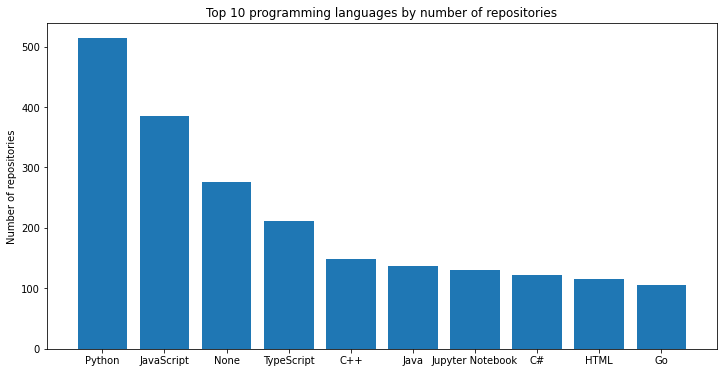

In [10]:
# Define the number of top languages to return, get the results, and plot them
num_results = 10
lang_repos = sort_results(language_stats, 'num_repos', num_results)
plot_result(lang_repos, 
          title=f'Top {len(lang_repos)} programming languages by number of repositories', 
          xlabel='', ylabel='Number of repositories')

# 2. Repositories with most commits

In [11]:
top_repos = my_pulsar.get_top_commits()

2022-06-03 19:25:25.580 INFO  [140320932513600] HandlerBase:64 | [persistent://public/static/initialized, reader-d4c41ed085, 6] Getting connection from pool
2022-06-03 19:25:25.582 INFO  [140320932513600] ConsumerImpl:224 | [persistent://public/static/initialized, reader-d4c41ed085, 6] Created consumer on broker [127.0.0.1:55018 -> 127.0.0.1:6650] 
2022-06-03 19:25:25.587 INFO  [140320932513600] ConsumerImpl:999 | [persistent://public/static/initialized, reader-d4c41ed085, 6] Closing consumer for topic persistent://public/static/initialized
2022-06-03 19:25:25.588 INFO  [140320932513600] ConsumerImpl:1055 | [persistent://public/static/initialized, reader-d4c41ed085, 6] Closed consumer 6

*** Showing partial results up to 2021-01-02 (info is still being processed) ***

2022-06-03 19:25:25.589 INFO  [140319980427008] HandlerBase:64 | [persistent://public/static/2021-01-02_result_commit, reader-df53b053d4, 7] Getting connection from pool
2022-06-03 19:25:25.590 INFO  [140319980427008] Con

In [12]:
pd.DataFrame(top_repos, columns=['Repository name','Number of commits'])

,Repository name,Number of commits
0,AOSP-Krypton/frameworks_base,661920
1,GiorgioComitini/COVID-19,107359
2,merchantsedition/merchantsedition,37380
3,WangTingMan/chromebase,21989
4,helaili/enterprise-showcase,12148
5,wiredfool/pillow-fuzz,11254
6,scriptex/uptime,10998
7,Ch4t4r/Nebulo,3465
8,itizaworld/webev,3290
9,extremscorner/libogc2,1935


# 3. Top languages with testdriven approach

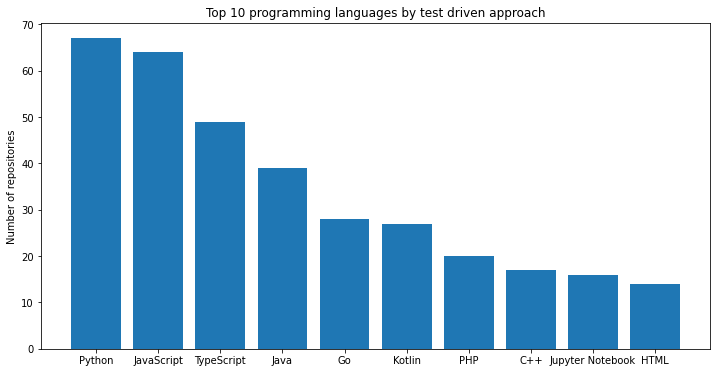

In [13]:
# Define the number of top languages to return, get the results, and plot them
num_results_test = 10
lang_repos_test = sort_results(language_stats, 'num_tests', num_results_test)
plot_result(lang_repos_test, 
          title=f'Top {len(lang_repos_test)} programming languages by test driven approach', 
          xlabel='', ylabel='Number of repositories')

# 4. Top languages with testdriven approach and continous integration

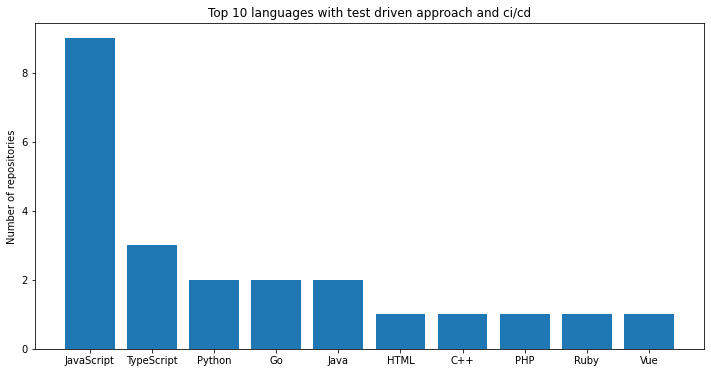

In [14]:
# Define the number of top languages to return, get the results, and plot them
num_results_ci = 10
lang_repos_ci = sort_results(language_stats, 'num_ci', num_results_ci)
plot_result(lang_repos_ci, 
          title=f'Top {len(lang_repos_ci)} languages with test driven approach and ci/cd', 
          xlabel='', ylabel='Number of repositories')

In [15]:
my_pulsar.close()

2022-06-03 19:25:46.692 INFO  [140320932513600] ClientImpl:496 | Closing Pulsar client with 3 producers and 8 consumers
2022-06-03 19:25:46.693 INFO  [140320932513600] ClientConnection:1559 | [127.0.0.1:55018 -> 127.0.0.1:6650] Connection closed
2022-06-03 19:25:46.694 INFO  [140320932513600] ClientConnection:263 | [127.0.0.1:55018 -> 127.0.0.1:6650] Destroyed connection
